




# This notebook has 5 sections -


1.   part 1 - cosine similarity
2.   part 2 - K-means using word2vec
3.   part 3 - extracting verbs via POS
4.   part 4 - Text Summarization
5.   part 5 - TSNE plot







**######### Part 1: Cosine similarity on word2Vec  ##########**


In [ ]:
'''
Cosine similarity on word2Vec embedding
Steps -
1. tokenize the sentences in each row of the "Case"
2. create a new column called "CaseCleaned_tokens"
3. implement word embedding method (word2vec) as features
4. append the vectors of each row to a new column called "case_embedding"
5. calculate the cosine similary between the query vector and each row of the entire abstract embedding column
6. append the similarity scores to a new column called "cosine_score"
7. sort the column and rank the top n cases with highest cosine score

**Reference - https://www.kaggle.com/yufenhou/recommender-system-eda-word2vec-cosine-similarity
'''


'\nCosine similarity on word2Vec embedding\nSteps -\n1. tokenize the sentences in each row of the "Case"\n2. create a new column called "CaseCleaned_tokens"\n3. implement word embedding method (word2vec) as features\n4. append the vectors of each row to a new column called "case_embedding"\n5. calculate the cosine similary between the query vector and each row of the entire abstract embedding column\n6. append the similarity scores to a new column called "cosine_score"\n7. sort the column and rank the top n cases with highest cosine score\n\n**Reference - https://www.kaggle.com/yufenhou/recommender-system-eda-word2vec-cosine-similarity\n'

In [ ]:
# download required libraries
import numpy as np 
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

#nltk.download("stopwords")
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read the csv
fileName = "/content/drive/My Drive/ISS/CompiledCases.csv"

column = "Case"
Data = pd.read_csv(fileName,encoding="Latin-1")
Data = Data.replace(np.nan,' ',regex=True)
sentences = list(Data[column])
Data.head()

,ID,Case
0,1,On behalf of Ms. Amira I would like to ask for...
1,2,The following information has been supplied by...
2,3,I hope you all are well and sane in these chal...
3,4,"The child protection office in Beirut, Lebanon..."
4,5,I am writing from Children and Families Across...


In [ ]:
Data.shape

(216, 2)

In [ ]:
###################################  Data Cleaning #######################################

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = nltk.corpus.stopwords.words('english')
#stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:

def data_preprocessing(text):
    
    text = ' '.join(re.sub('https?://\S+|www\.\S+','',text).split())
    text = text.replace('\n', '')
    text = re.sub("[!@#$+%*:()/<.=,—']", '', text)
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text



In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
ps = nltk.PorterStemmer()

import re
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
Data['CaseCleaned'] = Data['Case'].apply(lambda x: data_preprocessing(x.lower()))

In [ ]:
# to display more of the text content
pd.set_option('display.max_colwidth', 200)
Data.head(5)

,ID,Case,CaseCleaned
0,1,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info...",behalf m amira would like ask cooperation tracing biological mother perhaps family member biological mother possibly moved canada according information unhcr received however cannot sure lot infor...
1,2,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. The father of L...,following information supplied youth welfare office berlin social worker made child welfare alert responsible family since 2014 father lara fadi come lebanon deported back country 2017 massively c...
2,3,"I hope you all are well and sane in these challenging times. I kindly ask you for your support in the case of Anas, d.o.b. 30.06.2004. Unfortunately I have only few information about the case: The...",hope well sane challenging time kindly ask support case ana dob 30062004 unfortunately information case mother nadia anaslive syria contact â¦ mobile â¦ father â¦ life still hamburg family live...
3,4,"The child protection office in Beirut, Lebanon, requests ISS assistance regarding a 6-year-old Syrian child, currently living in Germany, in order to facilitate the re-establishment of contact bet...",child protection office beirut lebanon request i assistance regarding 6-year-old syrian child currently living germany order facilitate re-establishment contact father lebanon ensure possible reun...
4,5,"I am writing from Children and Families Across Borders, UK, to request your assistance on this case. It involves two children who are placed with foster carers in the UK. The foster carers travel ...",writing child family across border uk request assistance case involves two child placed foster carers uk foster carers travel lebanon frequently would like take child holiday child foster care chi...


Text(0.5, 1.0, 'Prominent words in Case Corpus Word Cloud')

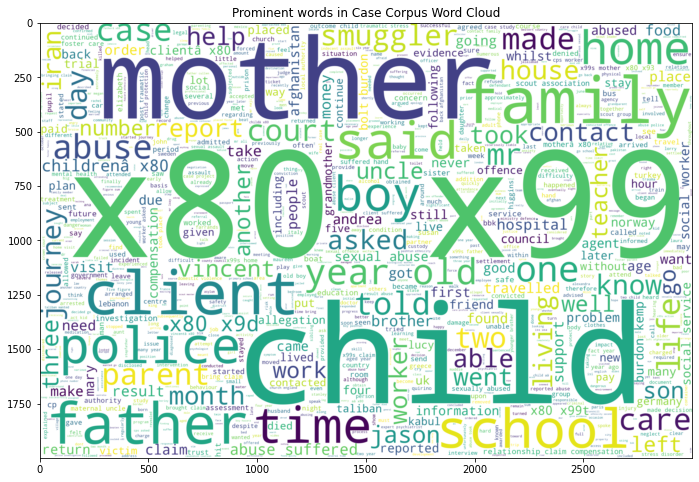

In [ ]:
contentCorpus = Data.CaseCleaned.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 3000,height = 2000,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Prominent words in Case Corpus Word Cloud')

In [ ]:
tokenized_sentences_clean = [sentence.split() for sentence in Data['CaseCleaned'].values]

In [ ]:
Data['CaseCleaned_tokens'] = tokenized_sentences_clean

In [ ]:
Data.head(5)

,ID,Case,CaseCleaned,CaseCleaned_tokens
0,1,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info...",behalf m amira would like ask cooperation tracing biological mother perhaps family member biological mother possibly moved canada according information unhcr received however cannot sure lot infor...,"[behalf, m, amira, would, like, ask, cooperation, tracing, biological, mother, perhaps, family, member, biological, mother, possibly, moved, canada, according, information, unhcr, received, howeve..."
1,2,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. The father of L...,following information supplied youth welfare office berlin social worker made child welfare alert responsible family since 2014 father lara fadi come lebanon deported back country 2017 massively c...,"[following, information, supplied, youth, welfare, office, berlin, social, worker, made, child, welfare, alert, responsible, family, since, 2014, father, lara, fadi, come, lebanon, deported, back,..."
2,3,"I hope you all are well and sane in these challenging times. I kindly ask you for your support in the case of Anas, d.o.b. 30.06.2004. Unfortunately I have only few information about the case: The...",hope well sane challenging time kindly ask support case ana dob 30062004 unfortunately information case mother nadia anaslive syria contact â¦ mobile â¦ father â¦ life still hamburg family live...,"[hope, well, sane, challenging, time, kindly, ask, support, case, ana, dob, 30062004, unfortunately, information, case, mother, nadia, anaslive, syria, contact, â¦, mobile, â¦, father, â¦, life..."
3,4,"The child protection office in Beirut, Lebanon, requests ISS assistance regarding a 6-year-old Syrian child, currently living in Germany, in order to facilitate the re-establishment of contact bet...",child protection office beirut lebanon request i assistance regarding 6-year-old syrian child currently living germany order facilitate re-establishment contact father lebanon ensure possible reun...,"[child, protection, office, beirut, lebanon, request, i, assistance, regarding, 6-year-old, syrian, child, currently, living, germany, order, facilitate, re-establishment, contact, father, lebanon..."
4,5,"I am writing from Children and Families Across Borders, UK, to request your assistance on this case. It involves two children who are placed with foster carers in the UK. The foster carers travel ...",writing child family across border uk request assistance case involves two child placed foster carers uk foster carers travel lebanon frequently would like take child holiday child foster care chi...,"[writing, child, family, across, border, uk, request, assistance, case, involves, two, child, placed, foster, carers, uk, foster, carers, travel, lebanon, frequently, would, like, take, child, hol..."


In [ ]:
model = word2vec.Word2Vec(tokenized_sentences_clean, size = 100, min_count=1)

In [ ]:
def buildWordVector(word_list, size):
    #function to average all words vectors in a given paragraph
    vec = np.zeros(size)
    count = 0.
    for word in word_list:
        if word in model.wv:
            vec += model.wv[word]
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
Data['case_embedding'] = Data['CaseCleaned_tokens'].apply(lambda x: buildWordVector(x, size = 100))

In [ ]:
Data.shape

(216, 5)

In [ ]:
def embedding_query(query):
    query = query.split(' ')
    query_vec = np.zeros(100).reshape((1,100))
    count = 0
    for word in query:
        if word in model.wv:
            query_vec += model.wv[word]
            count += 1.
    if count != 0:
        query_vec /= count
    return query_vec

In [ ]:
def get_similarity(query,n_top):
    query_vec = embedding_query(query)
    Data["cos_sim"] = Data['case_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x],query_vec.reshape(1,-1))[0][0])
    top_list = (Data.sort_values("cos_sim", ascending=False)
                [["ID","Case","cos_sim"]]
                .drop_duplicates()[:n_top])
    return top_list

In [ ]:
#display top 5 similar cases to case 2
get_similarity('2',5)

,ID,Case,cos_sim
74,75,The child was taken into custodial care and lived in a swedish speaking family and was returned to the finnish speaking mother 4 months prior to death. The Childâs behavior was seen as. disobedi...,0.999580
66,67,"The child was crying more after turning 2 months, Several visits to health care Center. The Child was extremely sensitive to touching and handling especially when in fatherâs arms. when left alo...",0.999579
45,46,Carlos used to reside in New Jersey with his mother â until he wound up in the hospital with a head wound and a concussion. The hospitalâs child welfare staff found evidence of abuse by his mo...,0.999578
68,69,"The mother was stressed by family duties and was helpless with the baby. When she was left alone with the baby, she hit the babyâs head against a doorframe, dropped her and pressed the head with...",0.999577
87,88,"With no close family members available to help out, government support services were contacted to offer financial and emotional support. Care proceedings were not required.",0.999576


**######  PART 2: Kmeans to get Sentiment analysis #########**

In [ ]:
# source - https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/
from sklearn.cluster import KMeans


In [ ]:

from gensim.models import Word2Vec
model = word2vec.Word2Vec(tokenized_sentences_clean, min_count=1)


In [ ]:
print (list(model.wv.vocab))
print (len(list(model.wv.vocab)))
print (model['ask'])

['behalf', 'm', 'amira', 'would', 'like', 'ask', 'cooperation', 'tracing', 'biological', 'mother', 'perhaps', 'family', 'member', 'possibly', 'moved', 'canada', 'according', 'information', 'unhcr', 'received', 'however', 'cannot', 'sure', 'lot', 'search', 'lebanon', 'ngo', 'â\x80¦', 'already', 'tried', 'find', 'unfortunately', 'succeed', 'finding', 'contacted', 'assistance', 'matter', 'extensively', 'locate', 'without', 'success', 'colleague', 'also', 'orphanage', 'placed', 'respond', 'email', 'see', 'possibility', 'get', 'present', 'whereabouts', 'amira?', 'available', 'refer', 'enclosed', 'case', 'note', 'document', 'thank', 'much', 'looking', 'forward', 'hear', 'contact', 'question', 'thought', 'mind', 'know', 'parent', 'brother', 'sister', 'decided', 'give', 'amiraâ\x80\x99s', 'left', 'daughter', 'beirut', 'childrenâ\x80\x99s', 'home', 'called', 'first', 'nine', 'year', 'life', 'spent', 'living', 'age', 'invited', 'come', 'netherlands', 'refugee', 'involved', 'process', 'nowadays',

In [ ]:
similar = model.wv.most_similar('abuse')
print(similar)

[('client', 0.9999626874923706), ('police', 0.9999580979347229), ('claim', 0.9999561905860901), ('school', 0.9999518990516663), ('sexual', 0.9999512434005737), ('also', 0.9999510645866394), ('scout', 0.9999500513076782), ('case', 0.9999467730522156), ('time', 0.9999457597732544), ('court', 0.9999412894248962)]


In [ ]:

from nltk.cluster import KMeansClusterer
import nltk
 

In [ ]:
X = model[model.wv.vocab]

In [ ]:
#X = model[model.vocab]
#modelKmeans = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X)
#positive_cluster_center = model.wv.cluster_centers_[0]
#negative_cluster_center = model.wv.cluster_centers_[1]
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from sklearn import cluster
from sklearn import metrics

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#Data['Sentiment'] = assigned_clusters

In [ ]:
print ("Cluster id labels for inputted data")
print (len(labels))
#print ("Centroids data")
#print (centroids)

Cluster id labels for inputted data
6453


In [ ]:
Data.shape

(216, 6)

**######## PART 3: extracting verbs via POS  #########**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('treebank')
wsj = nltk.corpus.treebank.tagged_words()
wt = nltk.FreqDist(wsj)
[word + "/" + tag for (word, tag) in wt if tag.startswith("V")]

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


['join/VB',
 'is/VBZ',
 'publishing/VBG',
 'was/VBD',
 'named/VBN',
 'used/VBN',
 'make/VB',
 'has/VBZ',
 'caused/VBN',
 'exposed/VBN',
 'reported/VBD',
 'enters/VBZ',
 'causing/VBG',
 'show/VBP',
 'said/VBD',
 'makes/VBZ',
 'stopped/VBD',
 'using/VBG',
 'were/VBD',
 'reported/VBN',
 'appear/VBP',
 'bring/VB',
 "'re/VBP",
 'talking/VBG',
 'heard/VBD',
 'having/VBG',
 'studied/VBD',
 'have/VBP',
 'are/VBP',
 'led/VBD',
 'making/VBG',
 'replaced/VBN',
 'sold/VBN',
 'worked/VBD',
 'died/VBN',
 'expected/VBN',
 'surviving/VBG',
 'including/VBG',
 'diagnosed/VBN',
 'study/VBP',
 'appears/VBZ',
 'be/VB',
 'studied/VBN',
 'industrialized/VBN',
 'owned/VBN',
 'support/VB',
 'argue/VBP',
 'regulate/VB',
 'found/VBN',
 'does/VBZ',
 'have/VB',
 'classified/VBN',
 'according/VBG',
 'rejected/VBN',
 'explained/VBD',
 'imposed/VBD',
 'remaining/VBG',
 'outlawed/VBN',
 'made/VBD',
 'dumped/VBD',
 'imported/VBN',
 'poured/VBD',
 'mixed/VBD',
 'described/VBD',
 'hung/VBD',
 'ventilated/VBD',
 "'s/VBZ",

In [ ]:
#from nltk.corpus import reuters
from nltk.corpus import brown

In [ ]:
#nltk.download('reuters')
#reuters.categories()
nltk.download('brown')
brown.categories()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

#Part 4:  **Text Summarization**

In [ ]:
#src - https://www.kaggle.com/pemagrg/text-summarization-using-bert-gpt2-xlnet
!pip install bert-extractive-summarizer


     |████████████████████████████████| 1.3MB 5.9MB/s 
     |████████████████████████████████| 1.1MB 14.9MB/s 
     |████████████████████████████████| 890kB 34.6MB/s 
     |████████████████████████████████| 2.9MB 40.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ce2b76b22c9c05c601d7aa0f2b2276525b48fb052a00c5a50aef1bc65400effd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install transformers==2.2.0


     |████████████████████████████████| 368kB 4.3MB/s 
     |████████████████████████████████| 133kB 26.7MB/s 
     |████████████████████████████████| 6.8MB 18.5MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
ERROR: botocore 1.19.22 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: transformers 3.5.1
    Uninstalling transformers-3.5.1:
      Successfully uninstalled transformers-3.5.1


In [ ]:
!pip install spacy==2.0.12


     |████████████████████████████████| 22.0MB 1.3MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 39.9MB/s 
     |████████████████████████████████| 184kB 43.2MB/s 
     |████████████████████████████████| 153kB 47.3MB/s 
     |████████████████████████████████| 604kB 39.5MB/s 
     |████████████████████████████████| 256kB 41.2MB/s 
     |████████████████████████████████| 450kB 38.4MB/s 
  Created wheel for spacy: filename=spacy-2.0.12-cp36-cp36m-linux_x86_64.whl size=29062887 sha256=89d53e0a501f003212410260de287206b10ce463dabcfc2bda0124b920db8096
  Stored in directory: /root/.cache/pip/wheels/60/0b/bb/7c2e28db574dbb2358176934eddd32a1c5f838ba0bc23eaaab
  Created wheel for thinc: filename=thinc-6.10.3-cp36-cp36m-linux_x86_64.whl size=4121038 sha256=5bd00c096365f1bd8c73b0dbd35284d031fe858ff377b862c79be0f37689f15b
  Stored in directory: /root/.cache/pip/wheels/db/bc/e1/9b321b6b203288cf636a56e668ed5700076af4ed66062278ca
  Created wheel

In [ ]:
from summarizer import Summarizer,TransformerSummarizer


In [ ]:
body = '''
        On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. 
        The biological mother possibly moved to Canada, according to information the UNHCR received. 
        However, we cannot be sure and as there is not a lot of information about mother, we would like to search for the biological mother in Lebanon. 
        The NGO â€¦ already tried to find the biological mother, but unfortunately they did not succeed in finding her. 
        They contacted the UNHCR for assistance in this matter. The UNHCR tried extensively to locate the mother of Amira, 
        but without success. My colleague also contacted the orphanage where Amira was placed, 
        but unfortunately they did not respond to her emails. 
        Do you see possibilities to get more information about the present whereabouts of the biological mother of Amira? 
        For all available information I refer to enclosed case note and document. 
        Thank you very much for your cooperation and I am looking forward to hear from you. 
        Amira would like to get in contact with her biological mother and family. 
        She has a lot of questions and thoughts on her mind. Amira would like to know who her parents are, 
        if she has brothers or sisters and why her mother decided to give her up. Amiraâ€™s mother left her daughter at an orphanage in Beirut. 
        The childrenâ€™s home was called â€¦ The first nine years of her life, Amira spent living in childrenâ€™s homes. 
        At the age of nine she was invited to come to the Netherlands as a refugee. The UNHCR was involved in this process. 
        Nowadays, Amira is living in a sheltered home for disabled people. 
        The biological mother possibly moved to Canada, according to information the UNHCR received. 
        However, we cannot be sure and as there is not a lot of information about mother, we would like to search for the biological mother in Lebanon.
        '''

In [ ]:
model_transformer = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")

def model1(text):
  summaryTransformer = ''.join(model_transformer(text, min_length=60))
  return summaryTransformer

100%|██████████| 798011/798011 [00:00<00:00, 11194766.11B/s]


In [ ]:
Data['summary_XLNet'] = Data['Case'].apply(lambda x: model1(x))

In [ ]:
Data.head(3)

,ID,Case,CaseCleaned,CaseCleaned_tokens,case_embedding,cos_sim,summary_XLNet
0,1,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info...",behalf m amira would like ask cooperation tracing biological mother perhaps family member biological mother possibly moved canada according information unhcr received however cannot sure lot infor...,"[behalf, m, amira, would, like, ask, cooperation, tracing, biological, mother, perhaps, family, member, biological, mother, possibly, moved, canada, according, information, unhcr, received, howeve...","[-0.24668274483587027, -0.21893323539671572, 0.07650420525023946, -0.03213953511823837, 0.08240230074152351, 0.1750553672367735, 0.18799101836365564, -0.2317734383434678, 0.16874422207774567, -0.1...",0.999561,"On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to info..."
1,2,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. The father of L...,following information supplied youth welfare office berlin social worker made child welfare alert responsible family since 2014 father lara fadi come lebanon deported back country 2017 massively c...,"[following, information, supplied, youth, welfare, office, berlin, social, worker, made, child, welfare, alert, responsible, family, since, 2014, father, lara, fadi, come, lebanon, deported, back,...","[-0.2455655652081521, -0.21841253584433515, 0.07579014099378517, -0.03254691468289574, 0.0809504791791347, 0.1743269154733353, 0.18710800655432083, -0.23092734829987277, 0.16807274078583115, -0.12...",0.999565,The following information has been supplied by the Youth Welfare Office in Berlin The Social Worker who made the child welfare alert has been responsible for the family since 2014. Up until now th...
2,3,"I hope you all are well and sane in these challenging times. I kindly ask you for your support in the case of Anas, d.o.b. 30.06.2004. Unfortunately I have only few information about the case: The...",hope well sane challenging time kindly ask support case ana dob 30062004 unfortunately information case mother nadia anaslive syria contact â¦ mobile â¦ father â¦ life still hamburg family live...,"[hope, well, sane, challenging, time, kindly, ask, support, case, ana, dob, 30062004, unfortunately, information, case, mother, nadia, anaslive, syria, contact, â¦, mobile, â¦, father, â¦, life...","[-0.23482959473838075, -0.20821018955270826, 0.07272412524840423, -0.03067347863811879, 0.0780933971345674, 0.16648891771143554, 0.178461116966047, -0.22031093310992989, 0.16077757917940957, -0.11...",0.999563,"I kindly ask you for your support in the case of Anas, d.o.b. Unfortunately I have only few information about the case: The mother, Nadia and Anaslive in Syria (contact: â¦ mobile â¦ ) . The fam..."


In [ ]:
bert_model = Summarizer()
bert_summary = ''.join(bert_model(body, min_length=60))
print(bert_summary)

100%|██████████| 231508/231508 [00:00<00:00, 4202236.24B/s]


On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. However, we cannot be sure and as there is not a lot of information about mother, we would like to search for the biological mother in Lebanon. Amira would like to get in contact with her biological mother and family.


In [ ]:
GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
full = ''.join(GPT2_model(body, min_length=60))
print(full)

100%|██████████| 456318/456318 [00:00<00:00, 6783256.12B/s]


On behalf of Ms. Amira I would like to ask for your cooperation in tracing her biological mother and perhaps other family members. The biological mother possibly moved to Canada, according to information the UNHCR received. However, we cannot be sure and as there is not a lot of information about mother, we would like to search for the biological mother in Lebanon. My colleague also contacted the orphanage where Amira was placed, 
        but unfortunately they did not respond to her emails.


#Part 5: ***TSNE visulaization ***


In [ ]:
#Using  caseCleanedTokens for TSNE
##source -https://www.kaggle.com/sandeepbhogaraju/word2vec-for-text-summarization
import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

#initialize w2v parameters
w2v_model = Word2Vec(min_count=30,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
from time import time 
t = time()

w2v_model.build_vocab(tokenized_sentences_clean, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [ ]:
#Now actually train model on the list of list of words
t = time()

w2v_model.train(tokenized_sentences_clean, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

#Takes 10 mins for 79mil words.
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [ ]:
#This makes the model memory-efficient
w2v_model.init_sims(replace=True)

In [ ]:
#Save the Model to disk
w2v_model.save(fname_or_handle = "w2v_text_sum")

In [ ]:
#-------------------------DATA VISUALIZATION--------------------------#
import numpy as np
import pandas as pd
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from gensim.models import Word2Vec
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#LOAD A W2V Model
MODEL_NAME = 'w2v_text_sum'
EMAIL_W2V =  MODEL_NAME
email_model =  gensim.models.Word2Vec.load(EMAIL_W2V)

In [ ]:
import time

def tsne_plot(model):
    start =  time.time()
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    end = time.time()
    print('{} seconds taken to index the w2v model'.format(end-start))


    
    return x,y,labels

In [ ]:
def matplot_plot(x,y,labels):
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names,VECTOR_DIMENTION):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, VECTOR_DIMENTION), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
#Index Entire Vocab 
x,y,labels = tsne_plot(email_model)

2.324986219406128 seconds taken to index the w2v model


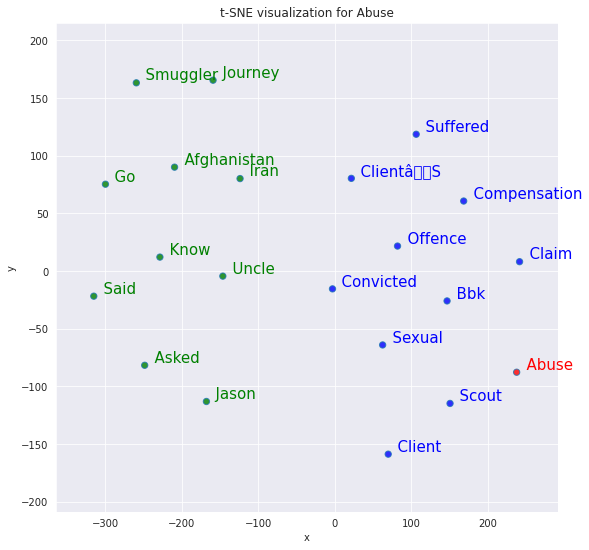

In [ ]:
#10 Most similar words vs. 10 Most dissimilar
## word in red, similar words in blue and different words in green

WORD ='abuse'
VECTOR_DIMENTION=200
list_names=[i[0] for i in email_model.wv.most_similar(negative=[WORD.lower()])]
tsnescatterplot(email_model,WORD.lower(),list_names,VECTOR_DIMENTION )